Annualized Stats: 

If monthly returns, annualization_factor = 12 
- Annual Returns = (data*annualization_factor).mean()
- Annual Vol = data.std() * np.sqrt(annualization_factor)


To compare performances 
- Look at their sharpe ratio
- look at their correlations on whether it introduces some form of diversification to the portfolio


Note: Tangency portfolios do not necessarily allocate to assets with higher sharpe ratios, they will also need to have a lower covariance / correlation with other assets. 


## Linear Regression: 
For TSLA, calculate the following metrics, relative to SPY:
- means TSLA: y variable, regress against x

Alpha an be annualized based on the annualizeation_factor

use the data through the end of 2022: means stop at 2022 (ie. data = retsx.loc[:'2022'])

## Hedge Fund Indices 
- HFRI: aggregates performance of hedge funds with x AUM (broad proxy of hedge fund performance)
- MLFM: high correlation to HFRI through linear factor decomposition
- MLFM-ES: includes tradable assets (alters the MLFM) -> allows ProsShares' ETF, HDG to track its performance

## Alternative Asset Class
An alternative asset class is simply an asset class that doesn't fall into the traditional equity or fixed income categories. Examples of this include illiquid investments such as Real Estate or Private Equity. Alternative assets typically have different regulations and fee-structures

## Alternative Strategy 
An alternative strategy is just a strategy that uses unconventional approaches to generating returns, such as by using shorting or leverage, or by targeting specific risk profiles, trading frequencies, or event based investing.*

## Performance Metrics 


Discuss the previous statistics, and what they tell us about...

* the differences between SPY and the hedge-fund series?
* which performs better between HDG and QAI.
* whether HDG and the ML series capture the most notable properties of HFRI.

__*(a)*__ *On average, these hedge fund series have around a 30 to 40% exposure to SPY as shown by their respective $\beta^{SPY}$. The Treynor Ratio, which measures the level of returns per unit of market risk (proxied by SPY), ranged from ~0.07 to ~0.14, while the mean return of SPY itself was close to 0.14. This seems to indicate that these hedge fund strategies underperformed even relative to the level of risk that was taken on. Lastly, the information ratio of all of these strategies was negative, which reflects their negative $\alpha$. In these regressions, $\alpha$ shows the hedge fund returns that could not be explained by the market. It seems that hedge funds have performed poorly over the past few years.*

__*(b)*__ *Between HDG and QAI there are some notable differences. First, QAI has slightly less exposure to market risk than does HDG, with their difference in betas at ~0.05. As an investor who may be attracted to hedge funds due to their diversification benefits, this difference could be quite meaningful. Secondly, even proportional to the level of market risk, QAI has higher returns.*

__*(c)*__ *Although HDG lags behind both HFRI and the ML series in terms of performance, both it and the ML series generally capture the most notable properties of HFRI. The level of market risk is quite similar to HFRI, which, as discussed by the case, is a driving factor of hedge fund investing. Again, these ETF returns are significantly lower than HFRI which could be a deterrent to potential investors.*

## TIPS

- Dropping TIPS from the investment set barely influenced the weights or the portfolio metrics
- so should we keep it? Yes, since they are separate and alternate asset classes, providing more diversification between TIPS and bonds than between SPY and other equity buckets (low correlation)
- direct protection to inflation 
- But when we added TIPs, it mostly impacted the allocation to domestic bonds and thus might be seen as another asset in that bucket

## Portfolio Allocation 
- Tangency porfolio looks for assets with: higher mean returns, lower vol, lower cov with other assets. Even an asset with a poor Sharpe ratio can be valuable in a portfolio if it has a low correlation with other assets. This asset may be optimized with a higher weight than assets with higher Sharpe ratios but higher correlations.

#### eg. if Tangency portfolio has a negative SR, due to the GMV below the x axis. However, this means that you short the tangency portfolio and long Rf. Look in terms of the absolute value of the SR. 

In [1]:
import pandas as pd 
import numpy as np 


hf_series = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='hedge_fund_series',index_col=0)
merrill_factors = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='merrill_factors',index_col=0)
other_data = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='other_data',index_col=0)
# print(hf_series)
data = hf_series
annualization_factor= 12

etfs = pd.read_excel("./../data/multi_asset_etf_data.xlsx", sheet_name="excess returns")
data = etfs 
data = data.set_index('Date')


def portfolio_metrics_basic(returns: pd.DataFrame, annualization_factor: float) -> pd.DataFrame: 
    '''
    Returns Annualized ER, Vol, SR, 
    '''
    
    returns_df = pd.DataFrame(index = returns.columns) 
    mu = returns.mean() * annualization_factor
    vol = returns.std() * np.sqrt(annualization_factor)
    sr = mu / vol

    
    returns_df['Annnualized Return'] = mu.values 
    returns_df['Annnualized Vol'] = vol.values 
    returns_df['Annnualized SR'] = sr.values
    
    return returns_df

portfolio_metrics_basic(data,annualization_factor)


/Users/patsy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,Annnualized Return,Annnualized Vol,Annnualized SR
BWX,-0.011888,0.081671,-0.145563
DBC,-0.009086,0.168455,-0.053935
EEM,0.026960,0.179940,0.149829
EFA,0.055037,0.152203,0.361605
HYG,0.037356,0.077289,0.483335
IEF,0.013939,0.063197,0.220561
IYR,0.077912,0.169585,0.459426
PSP,0.092851,0.215238,0.431386
QAI,0.014959,0.049007,0.305241
SPY,0.126983,0.143066,0.887578


In [185]:
def portfolio_metrics(returns: pd.Series, quantile: float) -> pd.DataFrame: 
    '''
    For each individual asset's returns 
    Information Ratio, Kurtosis, Skewness, vAr, cvar, max_dd
    '''
    
    # skewness -> dimensionless data
    
    skewness = returns.skew()

    # kurtosis-> dimensionless data
    kurtosis = returns.kurtosis()
    
    # var  
    # if annualized, multiply by np.sqrt(12)
    quantile_returns = returns.quantile(quantile)

    # cvar
    # if annualized, multiply by np.sqrt(12)
    quantile_cut_off = returns.quantile(quantile) 
    cvar = returns.loc[returns.values < quantile_cut_off].mean()

    # max_dd 
    cumulative = (returns + 1).cumprod()
    max_cumulative = cumulative.expanding().max()
    drawdown = cumulative / max_cumulative - 1
    max_dd = drawdown.min()
    peak_date = cumulative[:drawdown.idxmin()].idxmax().date()
    trough_date = drawdown.idxmin().date()
    recovery_date = cumulative[cumulative.index > drawdown.idxmin()].apply(lambda x: x >= max_cumulative[drawdown.idxmin()]).idxmax()

    if pd.isna(recovery_date):
        recovery_period = np.nan  # No recovery occurred
    else:
        recovery_date = recovery_date.date()
        recovery_period = (recovery_date - trough_date).days

    '''
Recovery Date: The first date after the trough when the portfolio reaches or exceeds its previous peak 
(i.e., it has fully recovered from the drawdown).

Recovery Period: This is the number of days between the trough date and the recovery date, 
indicating how long it took for the investment to recover from its drawdown back to its previous peak.


    '''

    return skewness, kurtosis, quantile_returns, cvar, max_dd, trough_date, peak_date, recovery_date, recovery_period

assets = list(data.columns)

s, k, var, cvar_s, max_dd_s, min_dates, peak_dates, recoveries, recovery_periods = zip(*[
    portfolio_metrics(data[asset], 0.05) for asset in assets
])

returns_df = pd.DataFrame(index = assets)
    
# not annualized
returns_df['Skewness'] = s
returns_df['Kurtosis'] = k
returns_df['var'] = var
returns_df['cvar'] = cvar_s
returns_df['peak_date'] = peak_dates
returns_df['min_date'] = min_dates
returns_df['max_dd'] = max_dd_s
returns_df['recovery'] = recoveries
returns_df['recovery'] = recovery_periods

returns_df

# what does recovery mean

,Skewness,Kurtosis,var,cvar,peak_date,min_date,max_dd,recovery
BWX,-0.184804,0.714401,-0.043311,-0.052614,2020-12-31,2023-10-31,-0.339522,30
DBC,-0.491710,0.708068,-0.083417,-0.113114,2011-04-30,2020-04-30,-0.669081,31
EEM,-0.104661,1.277024,-0.078424,-0.111063,2021-06-30,2022-10-31,-0.366400,30
EFA,-0.266527,0.967185,-0.073256,-0.096643,2021-08-31,2022-09-30,-0.276203,609
HYG,-0.482790,4.299609,-0.027397,-0.049028,2021-12-31,2022-09-30,-0.152857,31
IEF,-0.029644,0.098295,-0.030108,-0.038691,2020-07-31,2023-10-31,-0.267532,30
IYR,-0.458684,1.478125,-0.067934,-0.100602,2021-12-31,2023-10-31,-0.351580,30
PSP,-0.641633,2.574721,-0.100326,-0.140010,2021-10-31,2022-09-30,-0.452017,31
QAI,-0.538754,2.018508,-0.019026,-0.031692,2021-06-30,2022-09-30,-0.137591,31
SPY,-0.407580,0.858827,-0.065493,-0.085439,2021-12-31,2022-09-30,-0.239572,517


<Axes: title={'center': 'Hedge Fund Series Gross Returns'}, xlabel='Date'>

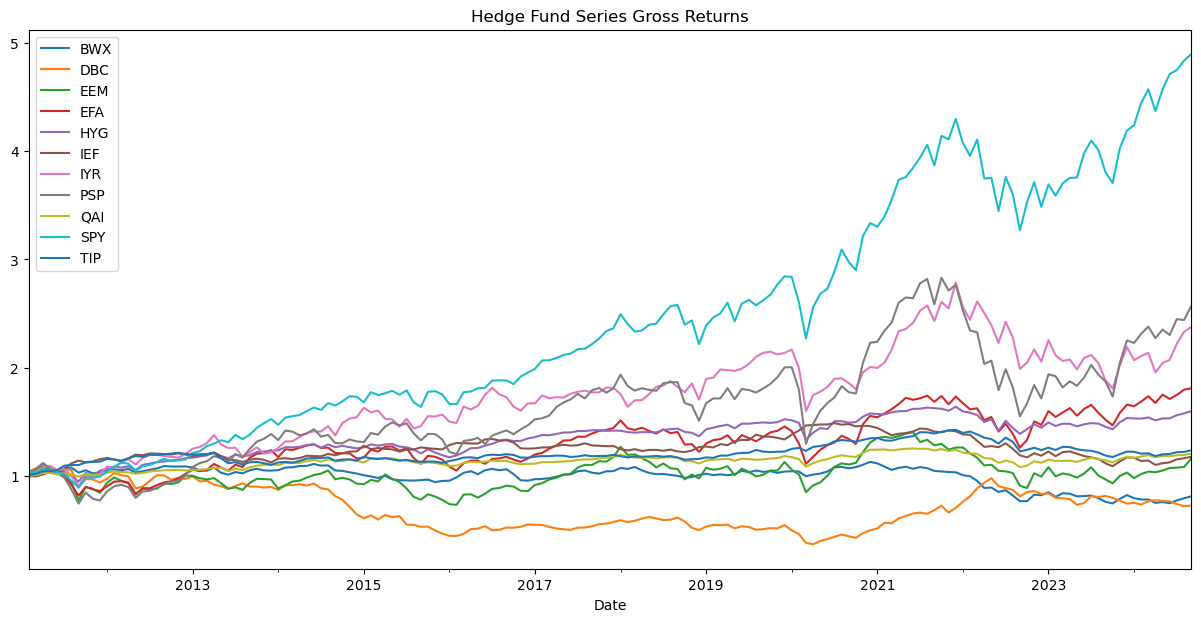

In [186]:
(data + 1).cumprod().plot(figsize=(15, 7), title='Hedge Fund Series Gross Returns')


MIN Correlation pair is ('IEF', 'DBC'), with a correlation of -0.30052272295503074
MAX Correlation pair is ('PSP', 'EFA'), with a correlation of 0.9105956995777845


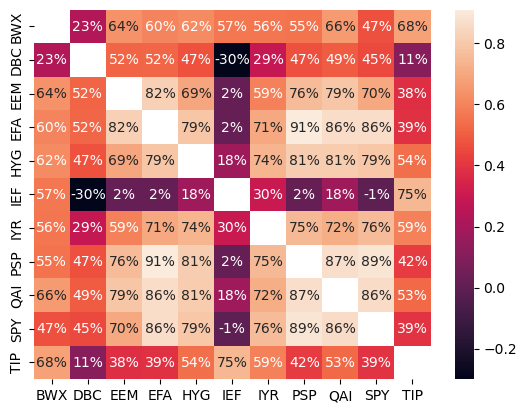

In [187]:
# correlation heatmap 

import seaborn as sns
import matplotlib.pyplot as plt

# full_df = pd.concat([spy.set_index('Date'), df], axis = 1)

def plot_corr(data: pd.DataFrame):
    corr_mtx = data.corr() 
    corr_mtx[corr_mtx==1] = None
    sns.heatmap(corr_mtx,annot=True,fmt='.0%');

    corr_rank = corr_mtx.unstack().sort_values().dropna()
    pair_max = corr_rank.index[-1]
    pair_min = corr_rank.index[0]

    min_corr_value = corr_rank.iloc[0]
    max_corr_value = corr_rank.iloc[-1]
    
    print(f'MIN Correlation pair is {pair_min}, with a correlation of {min_corr_value}')
    print(f'MAX Correlation pair is {pair_max}, with a correlation of {max_corr_value}')
    
plot_corr(data)

# Comparing Assets 

* SR, Mean, Vol
* Is it a good hedge / diversified tool?
- low corr to other assets (different baskets)
- high corr to assets within the same/similar basket

In [189]:
import numpy as np 

# returns is the main returns not annualized 
def tangency_weights(returns,dropna=True,scale_cov=1, name = 'Tangency'):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()
    tangency_weights_df = pd.DataFrame(weights, index=returns.columns, columns=[f'{name} Weights'])

    return tangency_weights_df

def equal_weights(returns): 
    return pd.DataFrame(index = returns.columns, data = 1/len(returns.columns), columns = ['EWP Weights'])

def gmv_weights(returns):
    ones = np.ones(returns.columns.shape)
    cov = returns.cov()* annualization_factor
    cov_inv = np.linalg.inv(cov)
    scaling = 1/(np.transpose(ones) @ cov_inv @ ones)
    gmv_tot = scaling * cov_inv @ ones
    gmv_weights_df = pd.DataFrame(gmv_tot, index=returns.columns, columns=['GMV Weights'])
    return gmv_weights_df

def risk_parity_weights(returns): 
    asset_var = returns.var().to_dict() 
    asset_inv_variance_dict = {asset: 1 / variance for asset, variance in asset_var.items()}
    rp_weights_df = pd.DataFrame.from_dict(asset_inv_variance_dict, orient='index', columns=['RP Weights'])
    return rp_weights_df



In [190]:
MU_MONTH_TARGET = 0.01 

def portfolio_returns_calc(data, weights_df): 
    return pd.DataFrame(data @ (weights_df.values)) 
    
tangency_weights_df = tangency_weights(data)
portfolio_returns = portfolio_returns_calc(data, tangency_weights_df)
portfolio_returns.columns = ['tangency_weights']
portfolio_tangency = portfolio_returns * MU_MONTH_TARGET / portfolio_returns.mean()
portfolio_tangency

,tangency_weights
Date,
2011-02-28,0.015249
2011-03-31,-0.003583
2011-04-30,-0.024090
2011-05-31,0.020357
2011-06-30,-0.000398
...,...
2024-05-31,0.031043
2024-06-30,0.057063
2024-07-31,-0.016777


Text(0.5, 1.0, 'Tangency Weights of Different Indices')

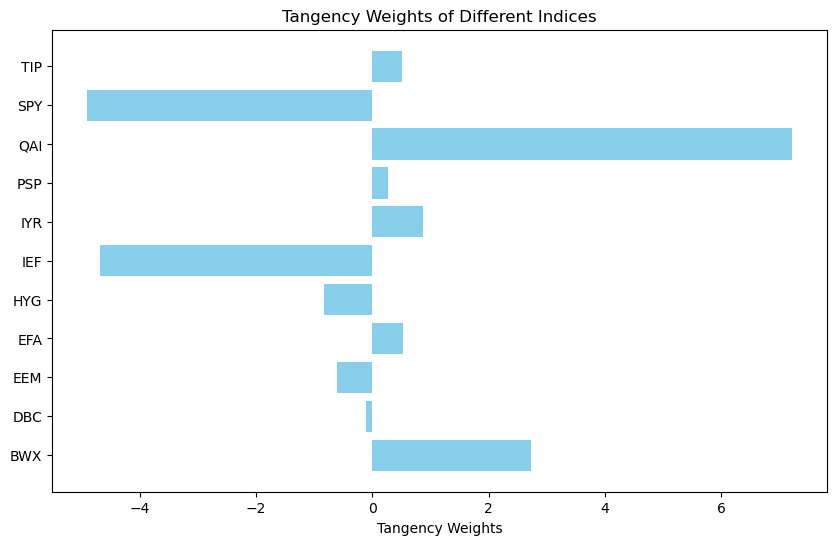

In [191]:
plt.figure(figsize=(10, 6))
plt.barh(tangency_weights_df.index, tangency_weights_df['Tangency Weights'], color='skyblue')
plt.xlabel('Tangency Weights')
plt.title('Tangency Weights of Different Indices')


In [192]:
equal_weights_df = equal_weights(data)
portfolio_returns = portfolio_returns_calc(data, equal_weights_df)
portfolio_returns.columns = ['equal_weights']
portfolio_ewp = portfolio_returns * MU_MONTH_TARGET / portfolio_returns.mean()
portfolio_ewp

,equal_weights
Date,
2011-02-28,0.060980
2011-03-31,0.025603
2011-04-30,0.104131
2011-05-31,-0.035098
2011-06-30,-0.046328
...,...
2024-05-31,0.063925
2024-06-30,0.004151
2024-07-31,0.063089


In [193]:
equal_weights_df

,EWP Weights
BWX,0.090909
DBC,0.090909
EEM,0.090909
EFA,0.090909
HYG,0.090909
IEF,0.090909
IYR,0.090909
PSP,0.090909
QAI,0.090909
SPY,0.090909


Text(0.5, 1.0, 'EWP Weights of Different Indices')

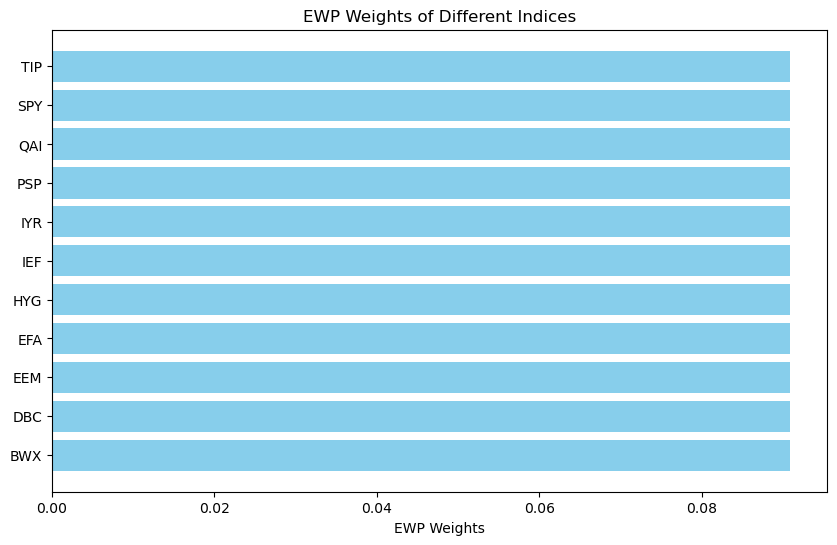

In [194]:
plt.figure(figsize=(10, 6))
plt.barh(equal_weights_df.index, equal_weights_df['EWP Weights'], color='skyblue')
plt.xlabel('EWP Weights')
plt.title('EWP Weights of Different Indices')


In [195]:
gmv_weights_df = gmv_weights(data)
portfolio_returns = portfolio_returns_calc(data, gmv_weights_df)
portfolio_returns.columns = ['gmv_weights']
portfolio_gmv = portfolio_returns * MU_MONTH_TARGET / portfolio_returns.mean()
portfolio_gmv

,gmv_weights
Date,
2011-02-28,0.175487
2011-03-31,-0.043927
2011-04-30,-0.320717
2011-05-31,-0.349980
2011-06-30,0.086579
...,...
2024-05-31,-0.067564
2024-06-30,0.083819
2024-07-31,0.100825


In [196]:
rp_weights_df = risk_parity_weights(data)
portfolio_returns = portfolio_returns_calc(data, rp_weights_df)
portfolio_returns.columns = ['rp_weights']
portfolio_rp = portfolio_returns * MU_MONTH_TARGET / portfolio_returns.mean()
portfolio_rp

,rp_weights
Date,
2011-02-28,0.047690
2011-03-31,0.032566
2011-04-30,0.139159
2011-05-31,0.002996
2011-06-30,-0.032283
...,...
2024-05-31,0.077448
2024-06-30,0.007010
2024-07-31,0.091001


In [197]:
regularized_weights_df = tangency_weights(data, scale_cov=.5, name = 'Regularized')
portfolio_returns = portfolio_returns_calc(data, regularized_weights_df)
portfolio_returns.columns = ['reg_weights']
portfolio_reg = portfolio_returns * MU_MONTH_TARGET / portfolio_returns.mean() # this is scaled based on the required target
portfolio_reg

,reg_weights
Date,
2011-02-28,0.024063
2011-03-31,-0.011978
2011-04-30,0.002404
2011-05-31,0.020293
2011-06-30,-0.008892
...,...
2024-05-31,0.041103
2024-06-30,0.031826
2024-07-31,0.014307


In [198]:
portfolios = pd.concat([
    portfolio_tangency, 
    portfolio_ewp,
    portfolio_gmv,
    portfolio_rp,
    portfolio_reg
], axis=1)
portfolios.columns = [_.split('_')[0] for _ in portfolios.columns]
portfolio_metrics_basic(portfolios)

# with scaling already done to hit the expected returns

,Annnualized Return,Annnualized Vol,Annnualized SR
tangency,0.12,0.074765,1.605037
equal,0.12,0.291527,0.411625
gmv,0.12,0.943576,0.127176
rp,0.12,0.309515,0.387703
reg,0.12,0.102604,1.169541


MIN Correlation pair is ('rp', 'gmv'), with a correlation of -0.46320095700873437
MAX Correlation pair is ('rp', 'equal'), with a correlation of 0.9301397488235478


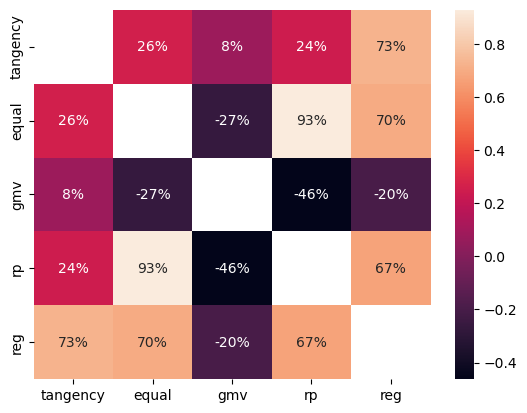

In [199]:
plot_corr(portfolios)

In [200]:
portfolios.head()

,tangency,equal,gmv,rp,reg
Date,,,,,
2011-02-28,0.015249,0.060980,0.175487,0.047690,0.024063
2011-03-31,-0.003583,0.025603,-0.043927,0.032566,-0.011978
2011-04-30,-0.024090,0.104131,-0.320717,0.139159,0.002404
2011-05-31,0.020357,-0.035098,-0.349980,0.002996,0.020293
2011-06-30,-0.000398,-0.046328,0.086579,-0.032283,-0.008892


In [201]:
portfolio_returns_df = pd.DataFrame(index = portfolios.columns)
    
s, k, var, cvar_s, max_dd_s, min_dates, peak_dates, recoveries, recovery_periods = zip(*[
    portfolio_metrics(portfolios[portfolio], 0.05) for portfolio in portfolios.columns
])

returns_df = pd.DataFrame(index = portfolios.columns)
    
returns_df['Skewness'] = s
returns_df['Kurtosis'] = k
returns_df['var'] = var
returns_df['cvar'] = cvar_s
returns_df['peak_date'] = peak_dates
returns_df['min_date'] = min_dates
returns_df['max_dd'] = max_dd_s
returns_df['recovery'] = recoveries
returns_df['recovery'] = recovery_periods

returns_df


,Skewness,Kurtosis,var,cvar,peak_date,min_date,max_dd,recovery
tangency,0.051780,0.105926,-0.025996,-0.033186,2022-07-31,2022-12-31,-0.078394,151
equal,-0.616344,2.157157,-0.121427,-0.189085,2021-12-31,2022-09-30,-0.529975,31
gmv,0.064148,1.790177,-0.414043,-0.583311,2011-02-28,2015-03-31,-0.999895,30
rp,-0.590209,1.565413,-0.140760,-0.203008,2021-08-31,2023-10-31,-0.705696,30
reg,-0.094926,1.024310,-0.040381,-0.056345,2021-12-31,2022-09-30,-0.165072,488


## No scaling done

In [203]:
# no scaling done just pure returns


wts = pd.DataFrame(index = data.columns, columns = ['tangency','equal weights',
                                                        'regularized', 'rp', 'gmv'])

wts.loc[:,'tangency'] = tangency_weights_df.values
wts.loc[:,'equal weights'] = equal_weights_df.values
wts.loc[:,'regularized'] = regularized_weights_df.values
wts.loc[:,'rp'] = rp_weights_df.values
wts.loc[:,'gmv'] = gmv_weights_df.values

wts


,tangency,equal weights,regularized,rp,gmv
BWX,2.730253,0.090909,-0.855638,1799.053371,-0.114821
DBC,-0.111241,0.090909,-0.172547,422.875611,-0.010196
EEM,-0.615698,0.090909,-0.083825,370.618768,-0.063409
EFA,0.530692,0.090909,0.047259,518.006421,0.024569
HYG,-0.832578,0.090909,0.401333,2008.858587,0.111199
IEF,-4.682480,0.090909,0.498538,3004.653551,-0.023018
IYR,0.877108,0.090909,0.101704,417.261797,-0.036137
PSP,0.277002,0.090909,0.062771,259.026648,-0.122724
QAI,7.220592,0.090909,-0.198272,4996.546298,1.14148
SPY,-4.904086,0.090909,0.790188,586.280583,-0.115092


In [204]:
wts_scaled = wts.copy()
wts_scaled *= (data.mean()@wts_scaled)

wts_scaled

# this is for scaled weights if the question doesnt state


,tangency,equal weights,regularized,rp,gmv
BWX,-0.119966,0.000304,-0.01084,61899.461123,0.000032
DBC,0.004888,0.000304,-0.002186,14549.747595,0.000003
EEM,0.027054,0.000304,-0.001062,12751.762883,0.000017
EFA,-0.023318,0.000304,0.000599,17822.883317,-0.000007
HYG,0.036583,0.000304,0.005085,69118.162918,-0.000031
IEF,0.205747,0.000304,0.006316,103380.165741,0.000006
IYR,-0.03854,0.000304,0.001289,14356.594848,0.00001
PSP,-0.012171,0.000304,0.000795,8912.248073,0.000034
QAI,-0.31727,0.000304,-0.002512,171914.590395,-0.000315
SPY,0.215484,0.000304,0.010011,20171.970857,0.000032


## OOS Performance

eg. using only data through the end of 2022 

means 

- IN_SAMPLE_END_DATE = "2022-12-31"
- OUT_OF_SAMPLE_START_DATE = "2023-01-01"

In [231]:
IN_SAMPLE_END_DATE = "2022-12-31"
OUT_OF_SAMPLE_START_DATE = "2023-01-01"

in_sample = data.loc[:IN_SAMPLE_END_DATE]
oos_sample = data.loc[OUT_OF_SAMPLE_START_DATE:]


is_tangency_weights_df = tangency_weights(in_sample)
is_equal_weights_df = equal_weights(in_sample)
is_gmv_weights_df = gmv_weights(in_sample)
is_risk_parity_weights_df = risk_parity_weights(in_sample)
is_regularized_weights_df = tangency_weights(in_sample, scale_cov=.5, name = 'Regularized')
in_sample_weights = (
    pd.concat([
        is_tangency_weights_df,
        is_equal_weights_df,
        is_gmv_weights_df,
        is_risk_parity_weights_df,
        is_regularized_weights_df,
    ], axis=1)
    .fillna(0)
)
in_sample_weights

,Tangency Weights,EWP Weights,GMV Weights,RP Weights,Regularized Weights
BWX,4.013468,0.090909,-0.111215,2013.897940,-0.771694
DBC,-0.645072,0.090909,-0.005440,390.186565,-0.075608
EEM,-1.172860,0.090909,-0.063411,358.515244,-0.078467
EFA,-0.032117,0.090909,0.037801,503.056786,0.032403
HYG,-1.347821,0.090909,0.103641,1896.372086,0.318590
IEF,-8.746713,0.090909,-0.005151,3340.173560,0.612332
IYR,1.563502,0.090909,-0.034320,440.405402,0.115935
PSP,1.983389,0.090909,-0.133506,261.119672,0.008595
QAI,15.023952,0.090909,1.120496,4911.695613,-0.307323
SPY,-9.591393,0.090909,-0.103563,564.924786,0.646499


In [237]:
in_sample_weights_scaled = (
    in_sample_weights
    .apply(lambda weights: weights * MU_MONTH_TARGET / (in_sample @ weights).mean())
)
in_sample_weights_scaled

,Tangency Weights,EWP Weights,GMV Weights,RP Weights,Regularized Weights
BWX,-0.503524,0.309565,6.092671,0.639716,-0.761197
DBC,0.080930,0.309565,0.298033,0.123943,-0.074580
EEM,0.147145,0.309565,3.473868,0.113883,-0.077400
EFA,0.004029,0.309565,-2.070860,0.159796,0.031962
HYG,0.169096,0.309565,-5.677761,0.602384,0.314257
IEF,1.097351,0.309565,0.282189,1.061008,0.604003
IYR,-0.196155,0.309565,1.880128,0.139895,0.114358
PSP,-0.248833,0.309565,7.313873,0.082945,0.008478
QAI,-1.884884,0.309565,-61.384191,1.560203,-0.303143
SPY,1.203323,0.309565,5.673518,0.179449,0.637705


In [241]:
in_sample_weights_scaled.abs().sum().to_frame("Sum of Absolute Weights")

,Sum of Absolute Weights
Tangency Weights,5.541334
EWP Weights,3.405220
GMV Weights,104.811589
RP Weights,6.102427
Regularized Weights,3.419036


In [257]:
columns = list(in_sample_weights_scaled.columns)
portfolio_df = pd.DataFrame()
for col in columns: 
    weights_df = in_sample_weights_scaled[col]
    portfolio_returns = portfolio_returns_calc(in_sample, weights_df)
    portfolio_returns.columns = [col]
    portfolio_df[col] = portfolio_returns
portfolio_metrics_basic(portfolio_df)

,Annnualized Return,Annnualized Vol,Annnualized SR
Tangency Weights,0.12,0.072139,1.663449
EWP Weights,0.12,0.332157,0.361275
GMV Weights,0.12,1.507455,0.079604
RP Weights,0.12,0.330685,0.362883
Regularized Weights,0.12,0.104833,1.144678


In [259]:
# repeat for OOS

# MV Optimization

MIN Correlation pair is ('RP Weights', 'GMV Weights'), with a correlation of -0.5077919469466288
MAX Correlation pair is ('RP Weights', 'EWP Weights'), with a correlation of 0.9140513826695106


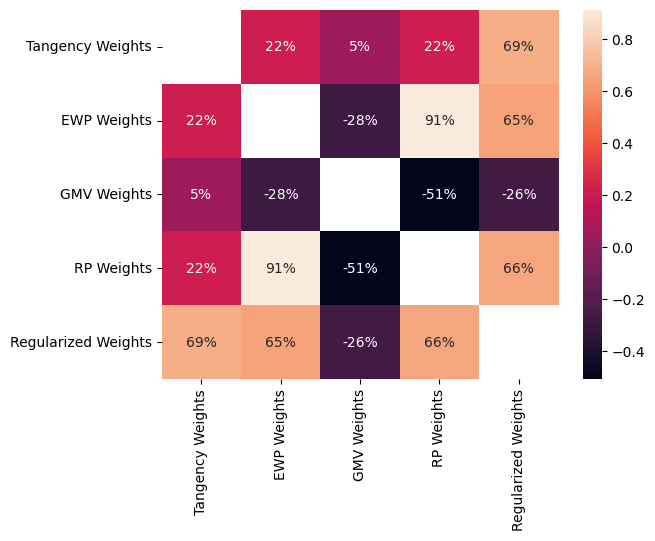

In [261]:
plot_corr(portfolio_df)

In [263]:
# portfolio optimization 

def mv_portfolio(target_ret, returns: pd.DataFrame):
    
    mu_tan = returns.mean() @ tangency_weights(returns,  1)
    mu_gmv = returns.mean() @ gmv_weights(returns)
    
    delta = (target_ret - mu_gmv[0])/(mu_tan[0] - mu_gmv[0])
    mv_weights = (delta * tangency_weights(returns,  1)).values + ((1-delta)*gmv_weights(returns)).values
    
    MV = pd.DataFrame(index = returns.columns, data = mv_weights, columns = ['MV Weights'] )
    MV['tangency weights'] =  tangency_weights(returns,  1).values
    MV['GMV weights'] =   gmv_weights(returns).values

    return MV


mv_portfolio(0.01, in_sample)


,MV Weights,tangency weights,GMV weights
BWX,-0.639347,4.013468,-0.111215
DBC,0.076459,-0.645072,-0.005440
EEM,0.078645,-1.172860,-0.063411
EFA,0.046754,-0.032117,0.037801
HYG,0.289489,-1.347821,0.103641
IEF,1.114136,-8.746713,-0.005151
IYR,-0.238908,1.563502,-0.034320
PSP,-0.404558,1.983389,-0.133506
QAI,-0.659729,15.023952,1.120496
SPY,1.111277,-9.591393,-0.103563


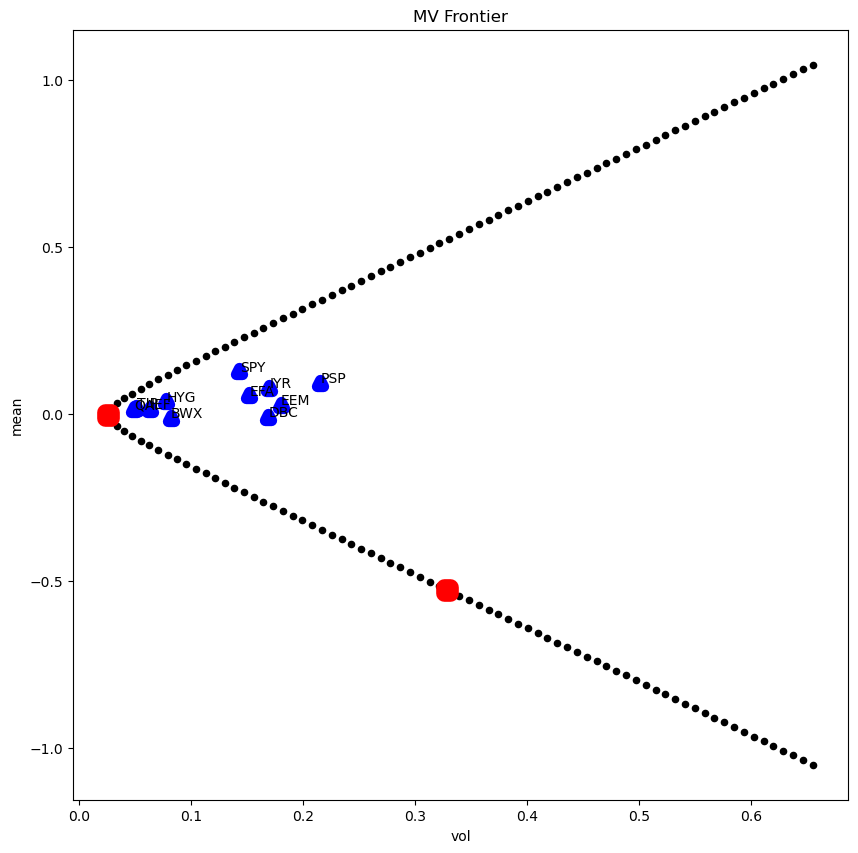

In [269]:
import warnings
warnings.filterwarnings('ignore')

def plot_ef(data):
    # for efficient frontier plots
    omega_tan = tangency_weights(data)
    rets_adj = data - data.mean() + 1
    omega_gmv = tangency_weights(rets_adj)
    omega = pd.concat([omega_tan,omega_gmv],axis=1)
    omega.columns = ['tangency','gmv']
    
    delta_grid = np.linspace(-2,2,150)
    mv_frame = pd.DataFrame(columns=['mean','vol'],index=delta_grid)
    for i, delta in enumerate(delta_grid):
        omega_mv = delta * omega_tan + (1-delta) * omega_gmv
        rets_p = data @ omega_mv
        mv_frame['mean'].iloc[i] = rets_p.mean().values[0] * annualization_factor
        mv_frame['vol'].iloc[i] = rets_p.std().values[0] * np.sqrt(annualization_factor)
        
    rets_special = pd.DataFrame(index=data.index)
    rets_special['tan'] = data @ omega_tan.values
    rets_special['gmv'] = data @ omega_gmv.values
    
    mv_assets = pd.concat([data.mean() * annualization_factor,data.std() * np.sqrt(annualization_factor)],axis=1)
    mv_special = pd.concat([rets_special.mean() * annualization_factor, rets_special.std() * np.sqrt(annualization_factor)],axis=1)
    mv_assets.columns = ['mean','vol']
    mv_special.columns = ['mean','vol']
    
    ax = mv_frame.plot.scatter(x='vol',y='mean', c='k', figsize=(10,10), title='MV Frontier')
    mv_assets.plot.scatter(x='vol',y='mean',ax=ax, c='b', marker='^', linewidth=8)
    mv_special.plot.scatter(x='vol',y='mean',ax=ax, c='r', marker='s', linewidth=12)
    
    for i in range(mv_assets.shape[0]):
        plt.text(x=mv_assets['vol'][i]+.0005, y=mv_assets['mean'][i]+.0005, s=mv_assets.index[i])

plot_ef(data)

# Factor Decomposition of Return Variation (Hedging vs Tracking) 


In [125]:
# Hedge ratio 
import numpy as np

def calculate_hedge_ratio(asset_returns, hedge_returns):
    # Calculate the standard deviations of both series
    sigma_asset = np.std(asset_returns)
    sigma_hedge = np.std(hedge_returns)
    
    # Calculate the correlation between the two series
    correlation = np.corrcoef(asset_returns, hedge_returns)[0, 1]
    
    # Calculate the hedge ratio
    hedge_ratio = correlation * (sigma_asset / sigma_hedge)
    
    return hedge_ratio

asset_returns = np.array([0.02, 0.03, -0.01, 0.04, 0.01])
hedge_returns = np.array([0.01, 0.02, 0.00, 0.03, 0.02])

hedge_ratio = calculate_hedge_ratio(asset_returns, hedge_returns)
print("Hedge Ratio:", hedge_ratio)

Hedge Ratio: 1.4615384615384617


## Treynor and Information Ratios

In [127]:
hf_series = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='hedge_fund_series',index_col=0)
merrill_factors = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='merrill_factors',index_col=0)
other_data = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='other_data',index_col=0)

In [128]:
import statsmodels.api as sm

# regress against SPY to understand the HF return's sensitivity to SPY 
# Looks at treynor and information ratios

# Simple Linear Regression 

x = 'SPY US Equity'
indices = list(hf_series.columns) 

combined_data = pd.merge(hf_series, merrill_factors[x], on = merrill_factors.index)
combined_data = combined_data.set_index('key_0')
results_df = pd.DataFrame(index = indices)

def eval_performance(data, y_variable, x_variable: str):
    y = data[y_variable]
    x = sm.add_constant(data[x_variable])
    
    model = sm.OLS(y, x).fit()
    r_squared = model.rsquared
    
    # Betas need not be annualized 
    beta = model.params[x_variable] # beta term (can be seen as the optimal hedge ratio) 
    alpha = model.params['const'] # alpha term
    annualized_alpha = alpha * 52
    residuals = model.resid 
    std_error = np.std(residuals, ddof=1)

    # Annualized ratios. 
    treynor_ratio = (y.mean() * annualization_factor)/beta # amount of returns from asset per unit of risk (beta) taken == systematic risk
    information_ratio = (alpha/std_error)  * np.sqrt(annualization_factor) # sharpe ratio of the non factor component of the return == active risk 
    # since its tracking error where it highlights the risk taken by deviating from the benchmark 

    annualized_return = data.mean() * annualization_factor 
    sortino_ratio = annualized_return / (data[data<0].std() * np.sqrt(annualization_factor))
    
    return beta, treynor_ratio, information_ratio, alpha, r_squared

# summary['Sortino Ratio'] = summary['Fitted Mean'] / y[y < 0].std()    # 
# summary['Annualized Sortino Ratio'] = summary['Sortino Ratio'] * np.sqrt(annual_factor)


for factor in indices: 
    
    outcomes = eval_performance(combined_data, factor, x)
    
    # Annualized 
    results_df.loc[factor, 'Alpha'] = outcomes[3] 
    results_df.loc[factor, 'Market Beta'] = outcomes[0]
    results_df.loc[factor, 'Treynor Ratio'] = outcomes[1]
    results_df.loc[factor, 'Information Ratio'] = outcomes[2] 
    results_df.loc[factor, 'R Square'] = outcomes[4] 
    
    
results_df
    


,Alpha,Market Beta,Treynor Ratio,Information Ratio,R Square
HFRIFWI Index,-0.000095,0.346131,0.139528,-0.035836,0.711480
MLEIFCTR Index,-0.001063,0.343383,0.105672,-0.491479,0.786051
MLEIFCTX Index,-0.001189,0.342171,0.101134,-0.549547,0.784862
HDG US Equity,-0.002123,0.352053,0.070478,-0.896268,0.763208
QAI US Equity,-0.001414,0.298376,0.085976,-0.675558,0.747822


## When to include alpha? 

- in the case of indices, its not necessary to include alpha to determine the composition since the index is mainly interested in their exposure to systematic risk factors which should ideally be fully explained by this linear combination.
- it should not be concerned about excess returns / alpha which is not explained fully
- but sometimes, alpha is used to de-mean the data so beta will just focus on decreasing standard devition around the data since alpha acts as a leveller to improve good fit for the betas around the dataset.


Recall: Factors affecting beta of the factors 
- correlation, number of regressors, amount of data points

eg. HF has 20% returns, alpha = 0. 
- this means the HF has leveraged beta (eg. beta = 2, * 10 leverage)
- regress against the market returns and test if its explained by the market
- types of HF: alpha capture, B trading (rolling regressions -> were they just overweight on things that did well) 

## Beta and optimal hedge ratio
eg. In the concept of hedging, optimal hedge ratio can be interpreted as the Beta for a simple linear regression 
- if beta = 0.2, to hedge, just short 20% of the asset on the portfolio. 
- As such, once the portfolio is hedged, just look at the remaining terms == alpha + error term 
- therefore, we end up looking at the error term which can be interprete d from the r**2 where high r**2 = small error, and this helps us to understand how hedged the portfolio is.


## Interpretation of ratios and intercept terms: 

- The alphas are negative which suggest that these indices did not provide any outperformance and they all underperformed SPY. Nonetheless, as their betas are positive, they have some positive influence on the SPY.
- However, when we include the standard errors and obtain the information ratios, they indicate a strong underperformance. Information ratio refers to the tradeoff between obtaining an extra mean return from alpha at the cost of a taking on the tracking error from the portfolio.
- In this case, since the IR is negative, there is a strong underperformance of the hedge funds.



QAI performs better since it has a lower beta (from the risk) and higher Treynor ratio = higher expected return per unit of market risk taken and a higher information ratio relative to the benchmark of the SPY.

## Replication Model

In [131]:
merrill_factors.head()

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
2011-08-31,-0.054976,0.000009,-0.092549,-0.087549,-0.005889,-0.088913
2011-09-30,-0.069420,0.000017,-0.179063,-0.108082,0.142180,-0.111505
2011-10-31,0.109147,-0.000013,0.162986,0.096274,-0.069502,0.151011
2011-11-30,-0.004064,0.000000,-0.019724,-0.021765,0.054627,-0.003784
2011-12-31,0.010449,0.000009,-0.042649,-0.021744,0.075581,0.005144


In [132]:
import statsmodels.api as sm


factors = list(merrill_factors.columns)
results_df = pd.DataFrame(index = list(factors), columns = ['Market Beta', 'Treynor Ratio', 'Information Ratio'])

# Multi Linear Regression model for replication to understand the tracking error

y_factor = 'HFRIFWI Index'
data = pd.merge(merrill_factors, hf_series[y_factor], on = hf_series.index) 


def get_params(data, y_col: str, x_col: list):
    columns = ['Alpha', 'R-Squared'] + x_col + ['Tracking Error']
    params_df = pd.DataFrame(index=columns)
    
    y = data[y_col]
    x = data[x_col]
    model = sm.OLS(y, x).fit()
    r_squared = model.rsquared
    betas = model.params
    p_values = model.pvalues

    
    tracking_error = (model.resid).std()*np.sqrt(annualization_factor) # tracking error represents the index tracking error to the actual underlying 
    # can be increased due to massive redemptions and creation processes which dislocate the prices 
    
    parameters = [0] + [r_squared] + list(betas) + [tracking_error]
    params_df['Without Intercept'] = parameters
    
    x = sm.add_constant(x)
    model_alpha = sm.OLS(y, x).fit()
    r_squared_model_alpha = model_alpha.rsquared
    betas_model_alpha = model_alpha.params[1:]
    alpha_model_alpha = model_alpha.params[0]
    p_values_model_alpha = model_alpha.pvalues
    
    tracking_error_alpha = (model_alpha.resid).std()*np.sqrt(annualization_factor)
    
    parameters = [alpha_model_alpha] + [r_squared_model_alpha] + list(betas_model_alpha) + [tracking_error_alpha]
    params_df['With Intercept'] = parameters

    return params_df 


# summary['Sortino Ratio'] = summary['Fitted Mean'] / y[y < 0].std()    # 
# summary['Annualized Sortino Ratio'] = summary['Sortino Ratio'] * np.sqrt(annual_factor)


get_params(data, y_factor, factors)




,Without Intercept,With Intercept
Alpha,0.000000,0.001235
R-Squared,0.845162,0.839676
SPY US Equity,0.050667,0.036483
USGG3M Index,0.499336,0.146336
EEM US Equity,0.080866,0.081611
EFA US Equity,0.079146,0.084638
EUO US Equity,0.031373,0.028806
IWM US Equity,0.142651,0.145111
Tracking Error,0.023908,0.023815


### Index Replication

In [134]:
hf_series = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='hedge_fund_series',index_col=0)
merrill_factors = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='merrill_factors',index_col=0)
other_data = pd.read_excel('./../data/proshares_analysis_data.xlsx',sheet_name='other_data',index_col=0)

##### Rolling Regression

<Axes: >

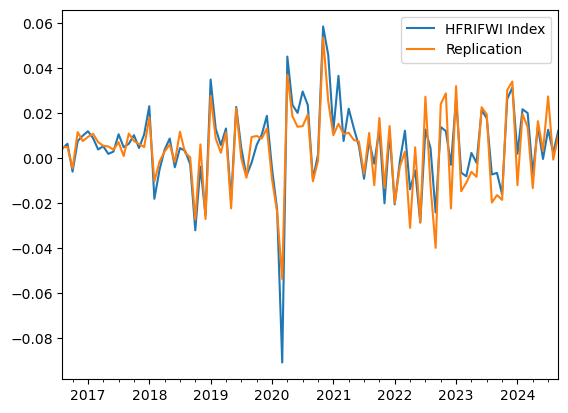

In [136]:
# Using the past n months as the in sample data 
# then start from n + 1 for out of sample data 

# method 1

n = 60 
length = len(hf_series['HFRIFWI Index'])

data = hf_series[['HFRIFWI Index']].copy()
data['Replication'] = np.nan

for i in range(n, length):
    
    y = hf_series['HFRIFWI Index'].iloc[i - 60:i]
    x = sm.add_constant(merrill_factors).iloc[i - 60:i]
    
    m = sm.OLS(y,x).fit()
    
    oos_val = sm.add_constant(merrill_factors).iloc[i].to_numpy().reshape((7))

    rep_val = m.predict(oos_val)
    
    data['Replication'].iloc[i] = rep_val

data.dropna().plot()

The OOS R-Squared of the replication is 0.7994


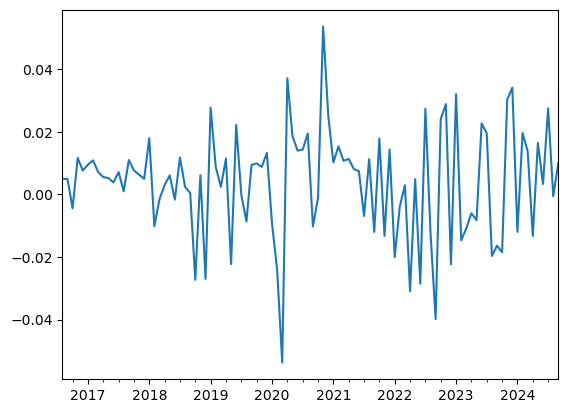

In [137]:
# method 2


x = sm.add_constant(merrill_factors)
y = hf_series['HFRIFWI Index']

from statsmodels.regression.rolling import RollingOLS
rolling = RollingOLS(y,x,window=60).fit()
rolling_betas = rolling.params
replication_rolling = (rolling_betas.shift() * x).dropna().sum(axis=1)
replication_rolling.plot()
oos_loss = (data.dropna().diff(axis=1)**2)['Replication'].sum()
oos_mean = data.dropna()['HFRIFWI Index'].mean()
oos_loss_null = ((data.dropna()['HFRIFWI Index'] - oos_mean)**2).sum()

oos_r2 = 1 - oos_loss / oos_loss_null

print(f'The OOS R-Squared of the replication is {round(oos_r2,4)}')

# interpreting Betas for hedging (Beta = edging ratio) 

- If long = 100M on a stock, hedge with the betas of other stocks. their betas will then be multiplied by -100M to gdetermine their exposures.
- Look at R square to understand how much of the variance of the stock is hedged. Check the annual tracking error where there can be large variations as well.
- if the amount hedged > initial amount position -> not practical

# interpreting Alphas for Hedging 
- High alpha : not explained well
- The annualized intercept is around 27%. This means that 27% of NVDA's returns are not explained by the other tech stocks. This is a very large number, and it means that the hedge is not very effective.

By including the intercept, we are assuming that the sample averages are not good predictors of the future averages. Thus we are allowing an intercept in the hedging regression, to ensure differences in mean returns do not impact the betas, which are the hedge recommendations.

If we really believed these sample averages are predictive, we would want the hedge ratios to account for that, and thus exclude an intercept, forcing these averages to impact the betas.

# interpreting Betas for Tracking

- betas represent the sensitivity of an asset or a portfolio's returns to the returns of a benchmark index (such as the S&P 500). The beta measures systematic risk, or the risk inherent to the market that cannot be diversified away.
- to determine position size, compare desired portfolio beta with current portfolio beta and divide it b asset beta

# interpreting Alphas for Hedging 
- want small alpha since cannot be invested in

## desire high R**2 to show it replicates well 